# Exemplo de uso.

## Parte 1: Processamentos iniciais.

Como esta etapa pode demorar bastante tempo para rodar, dependendo da máquina, é possível pular diretamente para a etapa 2, partindo de um arquivo já processado que foi disponibilizado.

Importando as bilbiotecas que serão utilizadas.

In [3]:
import pandas as pd
import re
from unidecode  import unidecode
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import spacy

nltk.download('wordnet')
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Importando o *dataset* de exemplo `tweets_prefeitos_2020.csv.gzip`.

Como ele está compactado no formato `gzip`, é importante passar o parâmetro `compression='gzip'` para o método `read_csv` do *Pandas*.

In [4]:
df_tweets = pd.read_csv('../dados/tweets_prefeitos_2020.csv.gzip', compression='gzip')

Adicionando a informação de alinhamento partidário de acordo com o que foi estabelecido na Tabela 2 do *codebook*:

*"Table 2. Party's Alignment (%) with Bolsonaro Government"*.

In [5]:
data = {
    "party": [
        "PSL", "PATRIOTA", "DEM", "PSC", "NOVO", "PSDB", "MDB", "PP",
        "REPUBLICANOS", "PL", "PSD", "PTB", "SOLIDARIEDADE", "CIDADANIA",
        "PODEMOS", "PROS", "AVANTE", "PV", "PDT", "PSB", "REDE",
        "PCDOB", "PT", "PSOL"
    ],
    "alignment_with_bolsonaro_government_perc": [
        97, 94, 93, 93, 92, 92, 91, 91, 91, 90, 90, 90, 89, 87,
        77, 75, 74, 68, 48, 46, 36, 29, 20, 15
    ],
    "government_or_opposition_position": [
        "Governo", "Governo", "Governo", "Governo",
        "Governo", "Governo", "Governo", "Governo",
        "Governo", "Governo", "Governo", "Governo",
        "Governo", "Governo", "Neutro", "Neutro",
        "Neutro", "Neutro", "Oposição", "Oposição", "Oposição",
        "Oposição", "Oposição", "Oposição"
    ],
}

df_party_alignment = pd.DataFrame(data)

In [6]:
df_tweets = df_tweets.merge(df_party_alignment, how='left', on='party')
df_tweets['government_or_opposition_position'] = df_tweets['government_or_opposition_position'].fillna('Desconhecido')

Agora, é possível analisar quantos *tweets* existem por grupo político.

<AxesSubplot:xlabel='government_or_opposition_position'>

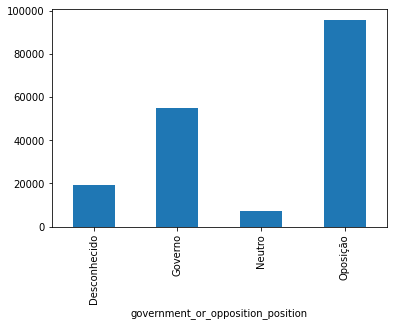

In [7]:
df_tweets.groupby('government_or_opposition_position')['id'].count().plot.bar()

Também, pode-se observar que existem postagens que estão em outros idiomas além do português.

In [8]:
df_tweets.groupby('lang')['id'].count().sort_values(ascending=False)

lang
pt     152577
en       7691
zxx      3784
und      3566
es       2781
qme      1943
it        805
fr        777
qht       634
art       573
ru        282
tl        273
de        247
qam       227
in        192
ja        181
tr        114
ro        103
ca         98
el         93
qst        89
nl         79
et         61
cs         52
eu         51
pl         49
da         49
fi         46
ht         46
lt         38
cy         38
no         26
vi         24
sv         22
ar         22
zh         21
hu         19
hi         18
uk         18
is         15
bg         15
sl         12
lv          9
iw          5
pa          3
kn          3
fa          2
ko          2
sr          1
te          1
Name: id, dtype: int64

Para este exemplo, selecionaremos apenas as postagens em português.

In [9]:
df_tweets = df_tweets[df_tweets['lang'] == 'pt']

Agora, para esta análise, vamos filtrar apenas as postagens relacionadas à pandemia de Covid-19 de acordo com os critérios estabelecidos no *codebook*, na Tabela 7:

*"Table 7. According to the topics, COVID-19 Vaccine and Vaccination Keywords used to collect Tweets from candidates in state capitals in 2020 and 2021"*.

No arquivo `covid_terms.csv` importado a seguir, constam todas as palavras-chave utilizadas para fazer esta seleção.

In [10]:
df_covid_terms = pd.read_csv('../dados/covid_terms.csv')
filter_terms = df_covid_terms['Keywords'].str.cat(sep='; ').split(';')
filter_terms = [s.strip() for s in filter_terms]
filter_terms = list(filter(None, filter_terms))

Pode-se visualizar os termos que serão utilizados como filtro.

In [11]:
filter_terms

['[Vv]acin',
 '[Vv]assina',
 '[Vv]acinacao',
 '[Vv]asina',
 '[li]munização',
 '[li]munisação',
 'Vaccine Symbol (0)',
 '[Oo]brigatoriedade',
 '[Oo]brigar',
 '[Cc]orona[Vv]ac',
 '[Cc]ova[Xx]in',
 '[Cc]omuna[Vv]ac',
 '[Ss]inovac',
 '[Aa]stra[Zz]eneca',
 '[Aa]stra[Zz]enica',
 '[Oo]xford',
 '[Oo]xfort',
 '[Oo]xfor',
 '[Vv]axzvria',
 '[Pp]fizer',
 '[Pp]eizer',
 '[Pp]pfaizer',
 '[Ff]aizer',
 '[Ff]eizer',
 '[Bb]arat',
 '[Bb]iontech',
 '[Bb]iontec',
 '[Cc]omyrnaty',
 '[Cc]omimaty',
 '[Bb]iontech [Mm]anufacturing [Gg]mbh',
 '[Vv]acina da [Mm]oderna',
 '[Vv]acina [Mm]oderna',
 '[Ss]pikevax',
 '[Mm]oderna',
 '[Bb]iontech',
 'mRNA-1273',
 'CX-024414',
 '[Ss]putnik',
 '[Ss]putinik',
 '[Ss]putink',
 '[Ss]putinic',
 '[Ss]putinikV',
 '[Gg]amaleya',
 '[Gg]amaleia',
 '[Jj]ansen',
 '[Jj]anssen',
 '[Jj]&[Jj]',
 '[Jj]ohnson & [Jj]ohnson',
 '[Jj]honson & [Jj]honson',
 '[Jj]onson',
 '[Jj] & [Jj]',
 '[Jj]ohnson',
 '[Jj]ohnsons',
 '[Jj]honson',
 '[Jj]ancen',
 '[Aa]d26.COV2S',
 '[Cc]ovaxin',
 '[Cc]ovachin',
 '[

Agora, o *dataset* será efetivamente filtrado.

In [12]:
df_tweets = df_tweets[df_tweets.text.str.contains('|'.join(filter_terms), regex=True, na=False, flags=re.IGNORECASE)]

C:\Users\andre\AppData\Local\Temp\ipykernel_11180\1253575287.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_tweets = df_tweets[df_tweets.text.str.contains('|'.join(filter_terms), regex=True, na=False, flags=re.IGNORECASE)]


E pode-se oberservar quantas postagens sobraram após a seleção.

In [13]:
len(df_tweets)

28506

Agora, é necessário realizar um pré-processamento no contéudo das postagens:
- Remover acentos;
- Transformar letras maiúsculas em minúsculas;
- Removre caracteres especiais;
- Remover stopwords;
- Lematização;
- etc.

In [14]:
# lista de stopwords em português
stopwords_list = stopwords.words('portuguese')
stopwords_list = [unidecode(w) for w in stopwords_list]

# stemmer
stemmer = RSLPStemmer()

# modelo do spacy utilizado para lematização
nlp = spacy.load('pt_core_news_sm')

def preprocess(text: str) -> str:
    """
    Função de pré-processamento de textos.
    """
    text = re.sub(r'https://t.co/(\w)*', ' ', text)                     # remove links
    text = re.sub(r'@\w+', ' ', text)                                   # remove os arrobas
    text = re.sub(r'#\w+', ' ', text)                                   # remove as hashtags
    text = text.lower()                                                 # minimiza o texto
    text = re.sub(r'\d+\/\d+\s', ' ', text)                             # remove contagem de posts

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]                            # lematização
    text = ' '.join(tokens)

    text = unidecode(text)                                              # remove acentos 
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                         # remove caracteres especiais
    text = re.sub(r'\s+', ' ', text)                                    # remove as quebras de linhas desnecessarias
    
    tokens = [word for word in text.split() if word not in stopwords_list]   # remove as stopwords
    
    return ' '.join(tokens)

Aplica o pré processamento para cada tweet.

In [15]:
df_tweets['text_processed'] = df_tweets.text.progress_apply(preprocess)

  0%|          | 0/28506 [00:00<?, ?it/s]

Cria features adicinais baseadas na texto.

In [16]:
df_tweets['content_len'] = df_tweets['text_processed'].astype(str).apply(len)
df_tweets['word_count'] = df_tweets['text_processed'].apply(lambda x: len(str(x).split()))

Cria features adicionais baseadas na data do *post*.

In [17]:
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at'])
df_tweets['year'] = df_tweets['created_at'].dt.year
df_tweets['month'] = df_tweets['created_at'].dt.month
df_tweets['day'] = df_tweets['created_at'].dt.day

Analisando as postagens através das features `content_len` e `word_count`, podemos notar que existem muitos *tweets* com pouco contéudo.

<AxesSubplot:title={'center':'Tweets X Número de Caracteres'}, xlabel='Tamanho do texto', ylabel='Frequência'>

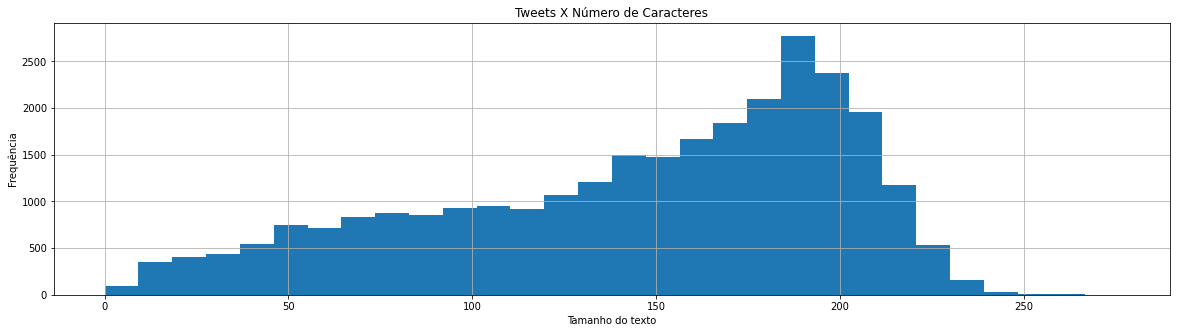

In [18]:
df_tweets.content_len.plot.hist(bins=30, grid=True, figsize=(20, 5), title='Tweets X Número de Caracteres', xlabel='Tamanho do texto', ylabel='Frequência')

<AxesSubplot:title={'center':'Tweets X Número De Palavras'}, xlabel='Número de palavras', ylabel='Frequência'>

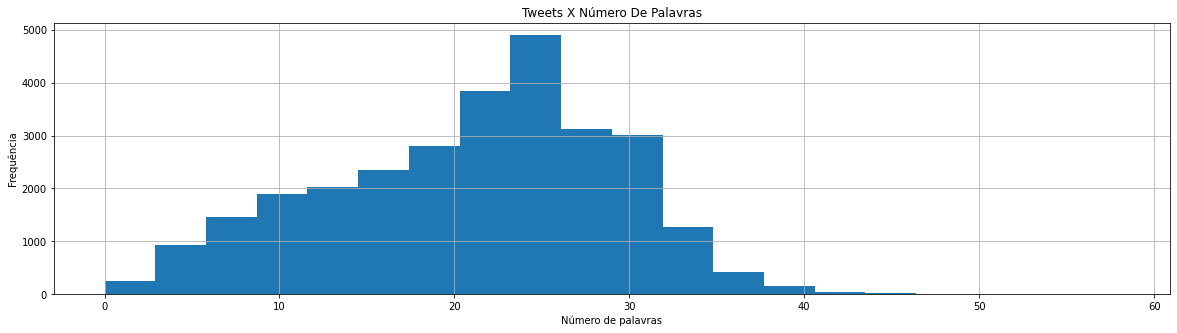

In [19]:
df_tweets.word_count.plot.hist(bins=20,grid=True, figsize=(20, 5), title='Tweets X Número De Palavras', xlabel='Número de palavras', ylabel='Frequência')

Para melhorar a aplicação do nosso modelo de LDA, vamos selecionar apenas as postagens com, no mínimo, 10 palavras.

In [20]:
df_tweets = df_tweets[df_tweets.word_count >= 10]

In [21]:
len(df_tweets)

25265

Salvando o dataset pré-processado que será utilizado como base para a próxima etapa.

In [22]:
df_tweets.to_csv('../dados/tweets_prefeitos_2020_preprocessado.csv.gzip', compression='gzip', index=False)